## Import libraries

In [40]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from nltk import FreqDist
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Bidirectional, LSTM, GRU, Conv1D, MaxPooling1D, MultiHeadAttention
from tensorflow.keras.metrics import Accuracy, Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint

## Load data

In [18]:
df = pd.read_csv("./Data/IMDB Dataset SPANISH.csv")
df.head()

,Unnamed: 0,review_en,review_es,sentiment,sentimiento
0,0,One of the other reviewers has mentioned that ...,Uno de los otros críticos ha mencionado que de...,positive,positivo
1,1,A wonderful little production. The filming tec...,Una pequeña pequeña producción.La técnica de f...,positive,positivo
2,2,I thought this was a wonderful way to spend ti...,Pensé que esta era una manera maravillosa de p...,positive,positivo
3,3,Basically there's a family where a little boy ...,"Básicamente, hay una familia donde un niño peq...",negative,negativo
4,4,"Petter Mattei's ""Love in the Time of Money"" is...","El ""amor en el tiempo"" de Petter Mattei es una...",positive,positivo


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   50000 non-null  int64 
 1   review_en    50000 non-null  object
 2   review_es    50000 non-null  object
 3   sentiment    50000 non-null  object
 4   sentimiento  50000 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


In [20]:
df = df[['review_es', 'sentimiento']]
df.head()

,review_es,sentimiento
0,Uno de los otros críticos ha mencionado que de...,positivo
1,Una pequeña pequeña producción.La técnica de f...,positivo
2,Pensé que esta era una manera maravillosa de p...,positivo
3,"Básicamente, hay una familia donde un niño peq...",negativo
4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


## Process data

In [21]:
def cleaning_sentence_es(sentence):
    sentence = re.sub(r'[^a-zA-ZáéíóúñÁÉÍÓÚÑ]', ' ', sentence)
    sentence = sentence.lower()
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [22]:
def tokenize_sentences(sentences):
    tokenized_sentences = []
    for sentence in sentences:
        tokenized_sentences.append(sentence.split())
    return tokenized_sentences

In [23]:
def vectorice_sentences(sentences, indexes):
    vectoriced_sentences = []
    for sentence in sentences:
        vectoriced_sentence = []
        for word in sentence:
            if word in indexes:
                vectoriced_sentence.append(indexes[word])
            else:
                vectoriced_sentence.append(0)
        vectoriced_sentences.append(vectoriced_sentence)
    return vectoriced_sentences

In [24]:
df['review_es'] = df['review_es'].apply(cleaning_sentence_es)
tokenized_sentences = tokenize_sentences(df['review_es'])

## Word Cloud

In [26]:
corpus = ' '.join(df['review_es'].to_list())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(corpus)

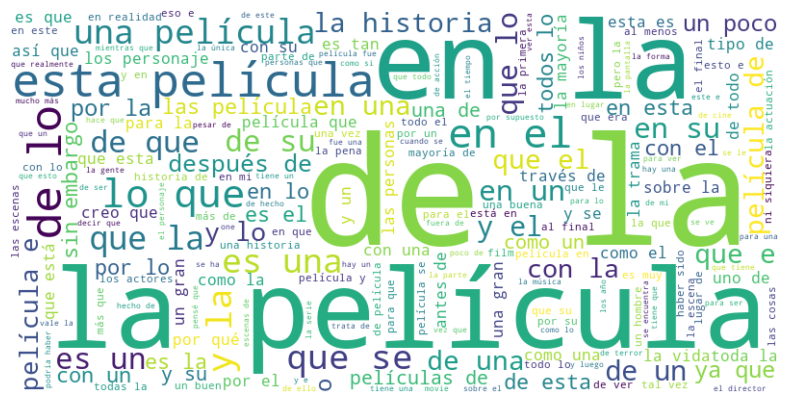

In [27]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Top words

In [11]:
words = []
for sentence in tokenized_sentences:
    words.extend(sentence)
frequency = FreqDist(words)
top_20 = frequency.most_common(20)
words, freq = zip(*top_20)

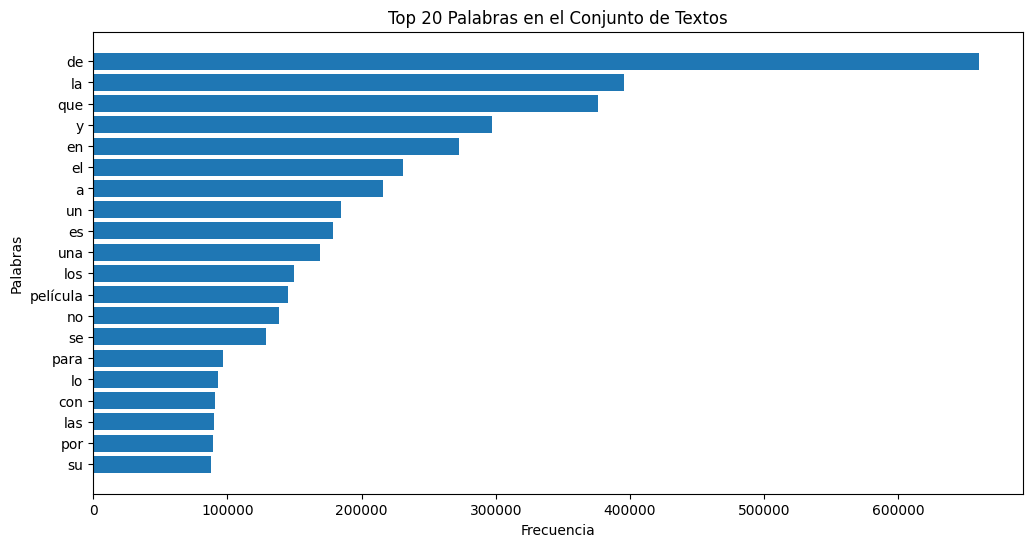

In [12]:
plt.figure(figsize=(12, 6))
plt.barh(words, freq)
plt.xlabel('Frecuencia')
plt.ylabel('Palabras')
plt.title('Top 20 Palabras en el Conjunto de Textos')
plt.gca().invert_yaxis() 
plt.show()

## Word2Vec Model

In [16]:
model_word2vec = Word2Vec(tokenized_sentences, vector_size=50, window=10, min_count=10, workers=4)
model_word2vec.train(tokenized_sentences,total_examples=model_word2vec.corpus_count, epochs=20)
model_word2vec.save("./Models/Word2Vec_es")

#### Semantically close words

In [17]:
model_word2vec.wv.most_similar('hombre')

[('anciano', 0.79112708568573),
 ('soldado', 0.7692601680755615),
 ('niño', 0.7586175203323364),
 ('hithombre', 0.7477133274078369),
 ('chico', 0.741767406463623),
 ('sacerdote', 0.7361106276512146),
 ('héroe', 0.7287939786911011),
 ('caballero', 0.7251530289649963),
 ('aristócrata', 0.7193958759307861),
 ('sirviente', 0.7113410830497742)]

In [18]:
model_word2vec.wv.most_similar('película')

[('historia', 0.7716356515884399),
 ('experiencia', 0.7242446541786194),
 ('imagen', 0.7019643187522888),
 ('películano', 0.6909438371658325),
 ('esto', 0.6804091930389404),
 ('trama', 0.6789206862449646),
 ('exageración', 0.6640154123306274),
 ('secuela', 0.6624366044998169),
 ('pieza', 0.6612792015075684),
 ('sensación', 0.6565989255905151)]

In [19]:
model_word2vec.wv.most_similar('crítico')

[('usuario', 0.7628124952316284),
 ('comentarista', 0.7312389016151428),
 ('revisor', 0.7294580340385437),
 ('comentario', 0.6752611398696899),
 ('sesgo', 0.6738072633743286),
 ('cristiano', 0.6059132814407349),
 ('imdb', 0.5989746451377869),
 ('marxista', 0.5774197578430176),
 ('póster', 0.5532394647598267),
 ('creyente', 0.548424482345581)]

In [20]:
model_word2vec.wv.most_similar('director')

[('guionista', 0.8465824127197266),
 ('cineasta', 0.8429282307624817),
 ('escritor', 0.8332958221435547),
 ('productor', 0.7459176778793335),
 ('proyecto', 0.7326512932777405),
 ('dp', 0.7112206220626831),
 ('guión', 0.6965793967247009),
 ('editor', 0.6951649188995361),
 ('altman', 0.6949503421783447),
 ('auteur', 0.6894435286521912)]

In [21]:
model_word2vec.wv.most_similar('araña')

[('tortuga', 0.8042064905166626),
 ('gigante', 0.7941181063652039),
 ('garra', 0.7585407495498657),
 ('robot', 0.7550362944602966),
 ('cascabel', 0.7430826425552368),
 ('serpiente', 0.7381449341773987),
 ('hierro', 0.7251847982406616),
 ('armadura', 0.7200594544410706),
 ('esqueleto', 0.718285083770752),
 ('lagarto', 0.7148287892341614)]

## Vectorize texts

In [25]:
model_word2vect = Word2Vec.load("./Models/Word2Vec_es")
indexes = model_word2vect.wv.key_to_index

In [26]:
maxlen = 150
max_words = len(indexes)

sequences = vectorice_sentences(tokenized_sentences, indexes)
X = pad_sequences(sequences, maxlen=maxlen)
y = df['sentimiento'].apply(lambda x : 1 if x == 'positivo' else 0).to_numpy()

## Split dataset into training and test

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Build embedding matrix

In [28]:
embedding_matrix = np.zeros((max_words, 50))
for word, i in indexes.items():
    if i < max_words:
        if word in indexes:
            embedding_matrix[i] = model_word2vect.wv[word]

## Plot confusion matrix

In [29]:
def plot_confusion_matrix(y_true, y_pred):
    
    conf_matrix = confusion_matrix(y_true, y_pred) 
    
    fig, ax = plt.subplots(figsize=(3, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.8)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='large')
 
    plt.xlabel('Predictions', fontsize=12)
    plt.ylabel('Actuals', fontsize=12)
    plt.title('Confusion Matrix', fontsize=12)
    plt.show()

## Bidirectional LSTM Model

In [34]:
model_lstm = Sequential()
model_lstm.add(Input(shape=(maxlen,)))
model_lstm.add(Embedding(input_dim=max_words, output_dim=50, weights=[embedding_matrix], trainable=False))
model_lstm.add(Bidirectional(LSTM(64, return_sequences=True)))  
model_lstm.add(Bidirectional(LSTM(64, return_sequences=True))) 
model_lstm.add(Flatten())
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid')) 

In [38]:
model_lstm.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', Recall(), Precision()]
)

model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 50)           1846400   
                                                                 
 bidirectional_2 (Bidirectio  (None, 150, 128)         58880     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 150, 128)         98816     
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 19200)             0         
                                                                 
 dense (Dense)               (None, 64)                1228864   
                                                                 
 dense_1 (Dense)             (None, 1)                

In [ ]:
checkpoint = ModelCheckpoint(
    './Models/model_lstm_es.h5', 
    monitor='val_accuracy',
    save_best_only=True,
    mode='max', 
    verbose=0
)  

model_lstm_history = model_lstm.fit(
    X_train, y_train, validation_split=0.2, 
    epochs=10, batch_size=128, callbacks=[checkpoint]
)

Epoch 1/10
250/250 [==============================] - 372s 1s/step - loss: 0.4451 - accuracy: 0.7882 - recall: 0.7901 - precision: 0.7863 - val_loss: 0.3483 - val_accuracy: 0.8432 - val_recall: 0.8500 - val_precision: 0.8387
Epoch 2/10
250/250 [==============================] - 347s 1s/step - loss: 0.3246 - accuracy: 0.8573 - recall: 0.8623 - precision: 0.8531 - val_loss: 0.3494 - val_accuracy: 0.8444 - val_recall: 0.9065 - val_precision: 0.8063
Epoch 3/10
  8/250 [..............................] - ETA: 5:15 - loss: 0.2979 - accuracy: 0.8721 - recall: 0.8563 - precision: 0.8758

In [ ]:
model_lstm = load_model("./Models/model_lstm_es.h5")
y_pred_lstm = np.round(model_lstm.predict(X_test).T).astype(int)[0]

In [ ]:
plot_confusion_matrix(y_test, y_pred_lstm)

In [ ]:
print(classification_report(y_test,y_pred_lstm))

## Bidirectional GRU Model

In [ ]:
model_gru = Sequential()
model_gru.add(Input(shape=(maxlen,)))
model_gru.add(Embedding(input_dim=max_words, output_dim=50, weights=[embedding_matrix], trainable=False))
model_gru.add(GRU(64, return_sequences=True))  
model_gru.add(GRU(64, return_sequences=True)) 
model_gru.add(Flatten())
model_gru.add(Dense(64, activation='relu'))
model_gru.add(Dense(1, activation='sigmoid')) 

In [ ]:
model_gru.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', Recall(), Precision()]
)

model_gru.summary()

In [ ]:
checkpoint = ModelCheckpoint(
    './Models/model_gru_es.h5', 
    monitor='val_accuracy',
    save_best_only=True,
    mode='max', 
    verbose=0
)  

model_gru_history = model_gru.fit(
    X_train, y_train, validation_split=0.2, 
    epochs=10, batch_size=128, callbacks=[checkpoint]
)

In [ ]:
model_gru = load_model("./Models/model_gru_es.h5")
y_pred_gru = np.round(model_gru.predict(X_test).T).astype(int)[0]

In [ ]:
plot_confusion_matrix(y_test, y_pred_gru)

In [ ]:
print(classification_report(y_test,y_pred_gru))

## CNN Model

In [ ]:
model_cnn = Sequential()
model_cnn.add(Input(shape=(maxlen,)))
model_cnn.add(Embedding(input_dim=max_words, output_dim=50, weights=[embedding_matrix], trainable=False))
model_cnn.add(Conv1D(256, kernel_size=8, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(64, kernel_size=4, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

In [ ]:
model_cnn.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', Recall(), Precision()]
)

model_cnn.summary()

In [ ]:
checkpoint = ModelCheckpoint(
    './Models/model_cnn_es.h5', 
    monitor='val_accuracy',
    save_best_only=True,
    mode='max', 
    verbose=0
)  

model_cnn_history = model_cnn.fit(
    X_train, y_train, validation_split=0.2, 
    epochs=10, batch_size=128, callbacks=[checkpoint]
)

In [ ]:
model_cnn = load_model("./Models/model_cnn_es.h5")
y_pred_cnn = np.round(model_cnn.predict(X_test).T).astype(int)[0]

In [ ]:
plot_confusion_matrix(y_test, y_pred_cnn)

In [ ]:
print(classification_report(y_test,y_pred_cnn))